In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


In [2]:
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from gensim.models import Word2Vec

import re
import time

## STEP 1. 형태소 분석기 이용해서 명사 추출

In [3]:
mecab = Mecab()

def read_txt(file_name):
    data = []
    start = time.time()
    with open(f'./data/{file_name}', 'r') as file:
        while True:

            line = file.readline()
            line = re.sub("[ ]+" ," ", line)
            line = line.strip()
            if not line: 
                break

            words = mecab.morphs(line)
            words = [word for word in words if len(word) != 1]
            data += [words]

    end = time.time()
    print(f"{file_name} 걸린 시간 : {end - start}")
    return data

file_name = "synopsis_SF.txt"
data = read_txt(file_name)

synopsis_SF.txt 걸린 시간 : 0.30521321296691895


## STEP 2. 추출된 명사로 Embedding model

In [4]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(data, vector_size=100, window=5, min_count=3, sg=1)  
model.wv.most_similar(positive=['SF'])

[('기술', 0.9984903931617737),
 ('작전', 0.9984236359596252),
 ('소년', 0.9983835816383362),
 ('흔적', 0.9983775019645691),
 ('감염', 0.9983707070350647),
 ('돌아가', 0.998367190361023),
 ('사이', 0.9983633160591125),
 ('이끄', 0.9983513355255127),
 ('돌아온', 0.9983412027359009),
 ('역사', 0.9983409643173218)]

## STEP 3. target, attribute 단어 셋 만들기

In [5]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['예술','일반','SF', '가족', '공연', '공포', '기타', '다큐멘터리', '드라마', '로맨스', '뮤지컬', '미스터리', '범죄', '역사', '서부극',
         '성인', '스릴러', '애니메이션', '액션', '모험', '전쟁', '코미디', '판타지']

- 공포(호러)가 없음..

In [6]:
# 전체 데이터 불러오기
data = []
for txt in genre_txt:
    data += read_txt(txt)
    
model = Word2Vec(data, vector_size=100, window=5, min_count=3, sg=1)  

synopsis_SF.txt 걸린 시간 : 0.34241485595703125
synopsis_family.txt 걸린 시간 : 0.10925769805908203
synopsis_show.txt 걸린 시간 : 0.10584783554077148
synopsis_horror.txt 걸린 시간 : 0.8192803859710693
synopsis_etc.txt 걸린 시간 : 0.6431286334991455
synopsis_documentary.txt 걸린 시간 : 2.061370372772217
synopsis_drama.txt 걸린 시간 : 5.315662145614624
synopsis_romance.txt 걸린 시간 : 1.417963981628418
synopsis_musical.txt 걸린 시간 : 0.0459902286529541
synopsis_mystery.txt 걸린 시간 : 0.21594858169555664
synopsis_crime.txt 걸린 시간 : 0.38861870765686035
synopsis_historical.txt 걸린 시간 : 0.05109691619873047
synopsis_western.txt 걸린 시간 : 0.015069961547851562
synopsis_adult.txt 걸린 시간 : 0.6444830894470215
synopsis_thriller.txt 걸린 시간 : 0.5774686336517334
synopsis_animation.txt 걸린 시간 : 1.642392873764038
synopsis_action.txt 걸린 시간 : 1.539337158203125
synopsis_adventure.txt 걸린 시간 : 0.24342870712280273
synopsis_war.txt 걸린 시간 : 0.10564875602722168
synopsis_comedy.txt 걸린 시간 : 1.4191534519195557
synopsis_fantasy.txt 걸린 시간 : 0.15729475021362305


## STEP 4. 장르별 WEAT 계산하기

In [13]:
# 코사인 유사도
def cos_sim(i, j):
    return np.dot(i, j.T)/(np.linalg.norm(i)*np.linalg.norm(j))

In [14]:
from sklearn.cluster import KMeans
# 대표 단어 선정: KMeans 클러스터링 활용
def get_representative_words(model, genre_name, num_clusters=5):
    representative_words = {}
    for genre in genre_name:
        words = [word for word, _ in model.wv.most_similar(genre, topn=50) if word in model.wv]
        if len(words) < num_clusters:
            representative_words[genre] = words
            continue
        
        word_vectors = np.array([model.wv[word] for word in words])
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        kmeans.fit(word_vectors)
        
        cluster_centers = kmeans.cluster_centers_
        closest_words = []
        for center in cluster_centers:
            closest_word = min(words, key=lambda word: np.linalg.norm(model.wv[word] - center))
            closest_words.append(closest_word)
        representative_words[genre] = closest_words
    return representative_words

representative_words = get_representative_words(model, genre_name)

result = dict(representative_words)

In [15]:
# WEAT 점수 계산 함수 수정
def s(w, a, b, model):
    # 단어 w, a, b의 벡터를 가져오기
    w_vector = model.wv[w]  # w는 이제 word가 되어야 함
    similar_tar_attr_01 = [cos_sim(w_vector, model.wv[attr]) for attr in a]
    mean_similar_01 = np.mean(similar_tar_attr_01)

    similar_tar_attr_02 = [cos_sim(w_vector, model.wv[attr]) for attr in b]
    mean_similar_02 = np.mean(similar_tar_attr_02)

    return mean_similar_01 - mean_similar_02

In [16]:
# WEAT 점수 계산
def weat_score(w1, w2, a, b, model):
    mean_s_01 = []
    for w in w1:
        mean_s_01 += [s(w, a, b, model)]  # s() 함수에 model을 추가로 넘김
    mean01 = np.mean(mean_s_01)

    mean_s_02 = []
    for w in w2:
        mean_s_02 += [s(w, a, b, model)]  # s() 함수에 model을 추가로 넘김
    mean02 = np.mean(mean_s_02)

    return mean01 - mean02

In [21]:
target_words_01 = result[genre_name[0]]
target_words_02 = result[genre_name[1]]

art_bias = []
normal_bias = []
nothing_bias = []

for i in range(2, len(result)):
    attr_words_01 = result[genre_name[i]]
    for j in range(i + 1, len(result)):
        attr_words_02 = result[genre_name[j]]
        
        weat = weat_score(target_words_01, target_words_02, attr_words_01, attr_words_02, model)
        
        # Classify bias based on WEAT score
        if weat > 0.05:
            print(f"\"{genre_name[0]}\"는 \"{genre_name[i]}\"에 편향되어 있습니다. {weat}")
            art_bias += [genre_name[i]]
            print(f"\"{genre_name[1]}\"는 \"{genre_name[j]}\"에 편향되어 있습니다. {weat}")
            normal_bias += [genre_name[j]]
        elif weat < -0.05:
            print(f"\"{genre_name[0]}\" 장르는 \"{genre_name[j]}\" 장르에 편향되어 있습니다. {weat}")
            art_bias += [genre_name[j]]
            print(f"\"{genre_name[1]}\" 장르는 \"{genre_name[i]}\" 장르에 편향되어 있습니다. {weat}")
            normal_bias += [genre_name[i]]
        elif weat >= -0.05 and weat <= 0.05:
            print(f"\"{genre_name[0]}\" 장르는 편향되지 않은 장르입니다. {weat}")
            nothing_bias += [genre_name[j]]

"예술" 장르는 편향되지 않은 장르입니다. 0.04604503512382507
"예술" 장르는 편향되지 않은 장르입니다. -0.029757536947727203
"예술" 장르는 편향되지 않은 장르입니다. -0.021102815866470337
"예술" 장르는 편향되지 않은 장르입니다. -0.04132549464702606
"예술" 장르는 편향되지 않은 장르입니다. -0.007349297404289246
"예술" 장르는 "드라마" 장르에 편향되어 있습니다. -0.05292389541864395
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.05292389541864395
"예술" 장르는 "로맨스" 장르에 편향되어 있습니다. -0.08381594717502594
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -0.08381594717502594
"예술" 장르는 편향되지 않은 장르입니다. -0.028668366372585297
"예술" 장르는 편향되지 않은 장르입니다. -0.014570415019989014
"예술"는 "SF"에 편향되어 있습니다. 0.16917577385902405
"일반"는 "범죄"에 편향되어 있습니다. 0.16917577385902405
"예술" 장르는 편향되지 않은 장르입니다. 0.009437918663024902
"예술" 장르는 편향되지 않은 장르입니다. -0.010145474225282669
"예술" 장르는 편향되지 않은 장르입니다. -0.009945109486579895
"예술" 장르는 편향되지 않은 장르입니다. -0.03702744096517563
"예술"는 "SF"에 편향되어 있습니다. 0.06148523837327957
"일반"는 "애니메이션"에 편향되어 있습니다. 0.06148523837327957
"예술" 장르는 편향되지 않은 장르입니다. -0.03700776398181915
"예술" 장르는 편향되지 않은 장르입니다. -0.009862899780273438
"예술"는 "SF"에 편향되어 있습니다. 0.176631

"예술"는 "로맨스"에 편향되어 있습니다. 0.1453011929988861
"일반"는 "애니메이션"에 편향되어 있습니다. 0.1453011929988861
"예술" 장르는 편향되지 않은 장르입니다. 0.04680819809436798
"예술"는 "로맨스"에 편향되어 있습니다. 0.0739530473947525
"일반"는 "모험"에 편향되어 있습니다. 0.0739530473947525
"예술"는 "로맨스"에 편향되어 있습니다. 0.26044726371765137
"일반"는 "전쟁"에 편향되어 있습니다. 0.26044726371765137
"예술" 장르는 편향되지 않은 장르입니다. 0.014208070933818817
"예술" 장르는 편향되지 않은 장르입니다. -0.02155861258506775
"예술" 장르는 편향되지 않은 장르입니다. 0.014097929000854492
"예술"는 "뮤지컬"에 편향되어 있습니다. 0.19784413278102875
"일반"는 "범죄"에 편향되어 있습니다. 0.19784413278102875
"예술" 장르는 편향되지 않은 장르입니다. 0.0381062887609005
"예술" 장르는 편향되지 않은 장르입니다. 0.018522894009947777
"예술" 장르는 편향되지 않은 장르입니다. 0.018723264336586
"예술" 장르는 편향되지 않은 장르입니다. -0.008359076455235481
"예술"는 "뮤지컬"에 편향되어 있습니다. 0.09015360474586487
"일반"는 "애니메이션"에 편향되어 있습니다. 0.09015360474586487
"예술" 장르는 편향되지 않은 장르입니다. -0.00833939015865326
"예술" 장르는 편향되지 않은 장르입니다. 0.01880544424057007
"예술"는 "뮤지컬"에 편향되어 있습니다. 0.20529964566230774
"일반"는 "전쟁"에 편향되어 있습니다. 0.20529964566230774
"예술" 장르는 편향되지 않은 장르입니다. -0.04093

In [22]:
len(genre_name)

23

In [23]:
# 예술 분야에 편향된 장르
set(art_bias) - set(normal_bias)

{'로맨스', '코미디', '판타지'}

In [24]:
# 일반 분야에 편향된 장르
set(normal_bias) - set(art_bias) 

{'범죄', '전쟁'}

In [25]:
nothing_bias

['가족',
 '공연',
 '공포',
 '기타',
 '다큐멘터리',
 '뮤지컬',
 '미스터리',
 '역사',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '역사',
 '애니메이션',
 '공포',
 '기타',
 '다큐멘터리',
 '드라마',
 '뮤지컬',
 '미스터리',
 '역사',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '코미디',
 '기타',
 '다큐멘터리',
 '드라마',
 '뮤지컬',
 '미스터리',
 '역사',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '코미디',
 '다큐멘터리',
 '드라마',
 '로맨스',
 '뮤지컬',
 '미스터리',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '코미디',
 '드라마',
 '뮤지컬',
 '미스터리',
 '역사',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '로맨스',
 '뮤지컬',
 '미스터리',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '코미디',
 '스릴러',
 '액션',
 '코미디',
 '판타지',
 '미스터리',
 '역사',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '코미디',
 '역사',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '전쟁',
 '서부극',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '성인',
 '스릴러',
 '액션',
 '모험',
 '스릴러',
 '액션',
 '모험',
 '액션',
 '모험',
 '코미디',
 '모험',
 '코미디',
 '판타지']

## STEP 5. 예술, 일반장르 편향성 및 시각화

In [26]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

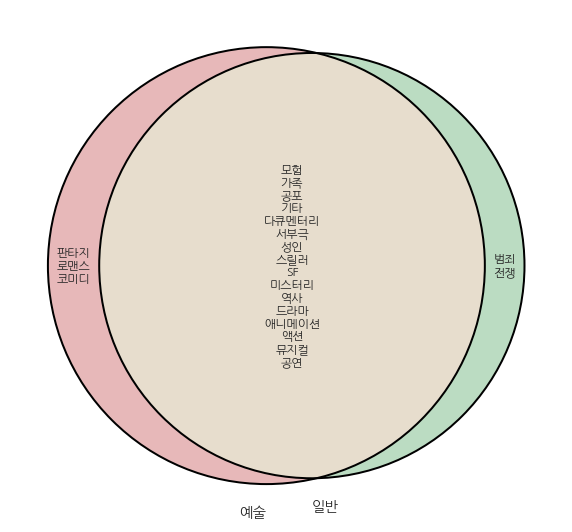

In [27]:
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2, venn2_circles

plt.figure(figsize = (10, 10))
A = set(art_bias) 
B = set(normal_bias) 
v = venn2(subsets=[A, B], set_labels=('예술', '일반')) 
c = venn2_circles(subsets=[A, B], linestyle='solid')

v.get_label_by_id('100').set_text('\n'.join(map(str,A-B)))
v.get_label_by_id('110').set_text('\n'.join(map(str,A&B)))
v.get_label_by_id('010').set_text('\n'.join(map(str,B-A)))